Data source: https://www.kaggle.com/datasets/ecoco2/household-appliances-power-consumption?select=radiator_309.csv

Step 1: Import Required Libraries

In [1]:
# Import necessary libraries
import pandas as pd
from interpreTS.utils.data_validation import validate_time_series_data
from interpreTS.utils.data_conversion import convert_to_time_series
from interpreTS.core.feature_extractor import FeatureExtractor, Features
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

# Version check for interpreTS
import interpreTS
print(f"Version: {interpreTS.__version__}")


C:\Users\nisia\AppData\Roaming\Python\Python312\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Version: 0.4.1


Step 2: Load and Inspect the Data

In [2]:
# Load the data
df = pd.read_csv('data/radiator.csv')

# Convert the 'timestamp' column to datetime and set it as the index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Preview the data
print(df.head())

# Get information about the dataset
df.info()

                           power
timestamp                       
2020-12-23 16:42:05+00:00    1.0
2020-12-23 16:42:06+00:00    1.0
2020-12-23 16:42:07+00:00    1.0
2020-12-23 16:42:08+00:00    2.5
2020-12-23 16:42:09+00:00    3.0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2592001 entries, 2020-12-23 16:42:05+00:00 to 2021-01-22 16:42:05+00:00
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   power   float64
dtypes: float64(1)
memory usage: 39.6 MB


Step 3: Validate and Convert the Data

In [29]:
# Validate the time series data
try:
    validate_time_series_data(df)
    print("Time series data validation passed.")
except (TypeError, ValueError) as e:
    print(f"Validation error: {e}")

# Convert the data into interpreTS TimeSeriesData object
time_series_data = convert_to_time_series(df)

# Print the converted TimeSeriesData object and its underlying data
print(time_series_data)
print(time_series_data.data)

Time series data validation passed.
                            power
timestamp                        
2020-12-23 16:42:05+00:00     1.0
2020-12-23 16:42:06+00:00     1.0
2020-12-23 16:42:07+00:00     1.0
2020-12-23 16:42:08+00:00     2.5
2020-12-23 16:42:09+00:00     3.0
...                           ...
2021-01-22 16:42:01+00:00  1178.0
2021-01-22 16:42:02+00:00  1167.0
2021-01-22 16:42:03+00:00  1178.0
2021-01-22 16:42:04+00:00  1190.0
2021-01-22 16:42:05+00:00  1190.0

[2592001 rows x 1 columns]


Step 4: Feature Extraction

In [4]:
# Initialize the FeatureExtractor
extractor = FeatureExtractor(
    features=[
        Features.MEAN, 
        Features.DOMINANT, 
        Features.TREND_STRENGTH, 
        Features.PEAK, 
        Features.VARIANCE
    ],
    window_size=60,  # Define the window size
    stride=30        # Define the stride
)

# Extract features from the time series data
features = extractor.extract_features(time_series_data.data)

# Display the extracted features
print(features.head())

   mean_power  dominant_power  trend_strength_power  peak_power  \
0  601.708333             1.0              0.755769      1314.0   
1  775.850000          1182.7              0.484017      1314.0   
2  176.033333             1.0              0.355786      1303.0   
3  380.816667             1.0              0.633966      1314.0   
4  808.200000          1182.8              0.009364      1314.0   

   variance_power  
0   421031.714336  
1   402910.943220  
2   194327.422599  
3   347499.270904  
4   359508.094915  


Step 5: Standardize the Features

In [5]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Print the shape of the scaled features
print(f"Scaled feature dimensions: {features_scaled.shape}")

Scaled feature dimensions: (86399, 5)


Step 6: Perform PCA Analysis

(a) Full PCA to Determine Optimal Number of Components

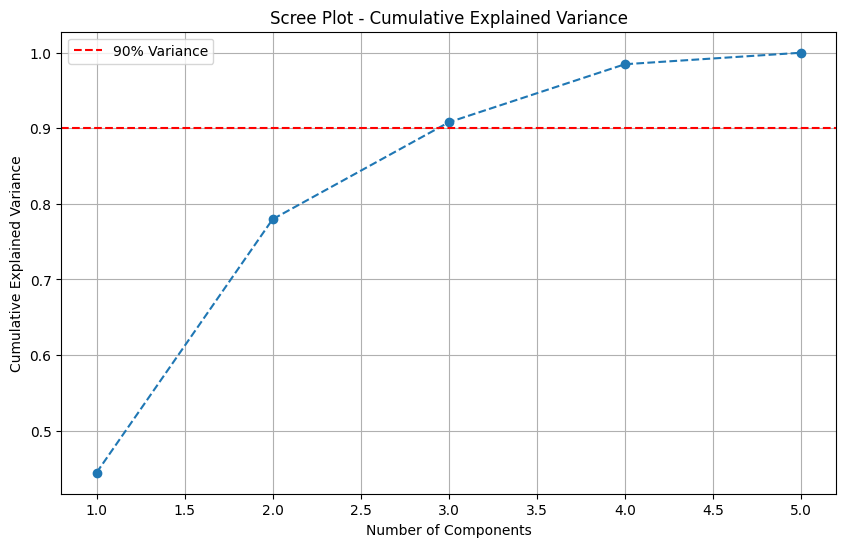

Number of components explaining at least 90% variance: 3


In [6]:
# Perform PCA with all components
pca = PCA()
pca_result = pca.fit_transform(features_scaled)

# Calculate the cumulative explained variance ratio
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance')
plt.title("Scree Plot - Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.grid()
plt.show()

# Determine the number of components needed to explain 90% of the variance
n_components_90 = np.argmax(explained_variance_ratio >= 0.9) + 1
print(f"Number of components explaining at least 90% variance: {n_components_90}")


(b) Apply PCA with Selected Number of Components

In [7]:
# Perform PCA with the optimal number of components
pca_final = PCA(n_components=n_components_90)
pca_final_result = pca_final.fit_transform(features_scaled)

# Get the PCA loadings (coefficients)
loadings = pca_final.components_
loading_df = pd.DataFrame(
    loadings.T, 
    columns=[f"PC{i+1}" for i in range(n_components_90)], 
    index=features.columns
)

# Display the PCA loadings
print("\nPCA Loadings:")
print(loading_df)


PCA Loadings:
                           PC1       PC2       PC3
mean_power           -0.629927  0.181104  0.174236
dominant_power       -0.597785  0.165984  0.157005
trend_strength_power  0.008113 -0.590912  0.800670
peak_power           -0.492595 -0.366028 -0.351975
variance_power       -0.055940 -0.675646 -0.424303


Step 7: Visualize PCA Results

(a) 2D Scatter Plot of PCA Results

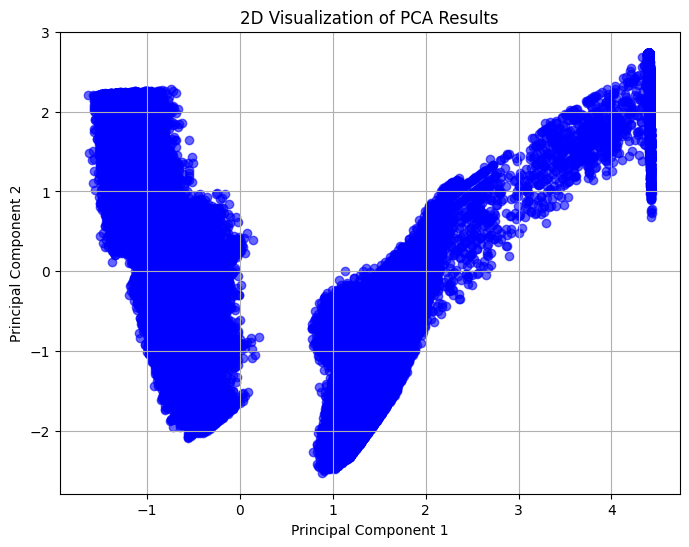

In [8]:
# Create a 2D scatter plot for the first two PCA components
plt.figure(figsize=(8, 6))
plt.scatter(pca_final_result[:, 0], pca_final_result[:, 1], c='blue', alpha=0.6)
plt.title("2D Visualization of PCA Results")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()


(b) 3D Scatter Plot of PCA Results

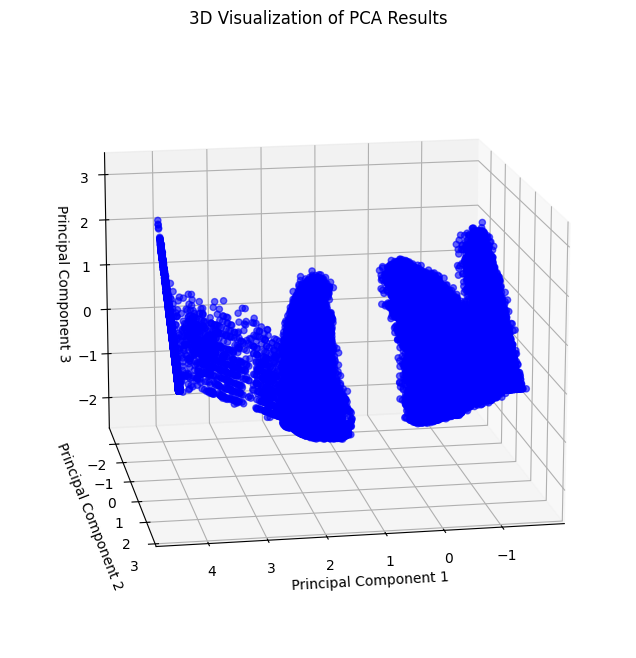

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

pca_df = pd.DataFrame(
    pca_final_result[:, :3], 
    columns=["PC1", "PC2", "PC3"]
)

x = pca_df["PC1"]
y = pca_df["PC2"]
z = pca_df["PC3"]

# Tworzenie wykresu 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c='blue', alpha=0.6)

# Dodanie tytułów osi
ax.set_title("3D Visualization of PCA Results")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")

# Ustawienie widoku (kąty widzenia kamery)
ax.view_init(elev=15, azim=80)  # Podmień `elev` (wysokość) i `azim` (kąt obrotu), aby zmienić widok

# Wyświetlenie wykresu
plt.show()


Step 8: Clustering

(a)  K-means Clustering

1. Finding the optimal number of clusters using the Elbow Method and Silhouette Score

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Searching for the optimal number of clusters using the "Elbow Method"
inertia = []
silhouette_scores = []
cluster_range = range(2, 6)  # Range of clusters to try

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_final_result)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(pca_final_result, kmeans.labels_))


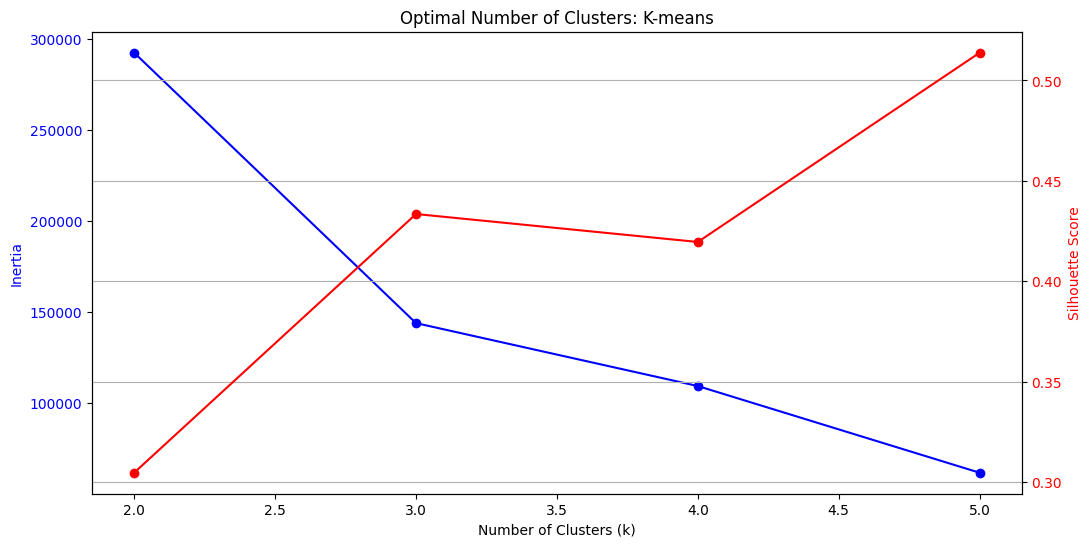

In [23]:
# Plot: Elbow Method and Silhouette Score
fig, ax1 = plt.subplots(figsize=(12, 6))

# Inertia (Elbow)
ax1.plot(cluster_range, inertia, 'bo-', label='Inertia')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Silhouette score
ax2 = ax1.twinx()
ax2.plot(cluster_range, silhouette_scores, 'ro-', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title("Optimal Number of Clusters: K-means")
plt.grid()
plt.show()

2. Choosing the optimal number of clusters

In [30]:
# Choose the optimal number of clusters (e.g., based on silhouette score or elbow method)
optimal_k = 2 
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(pca_final_result)


KMeans(n_clusters=2, random_state=42)

3. 3D Visualization of K-means Clustering Results

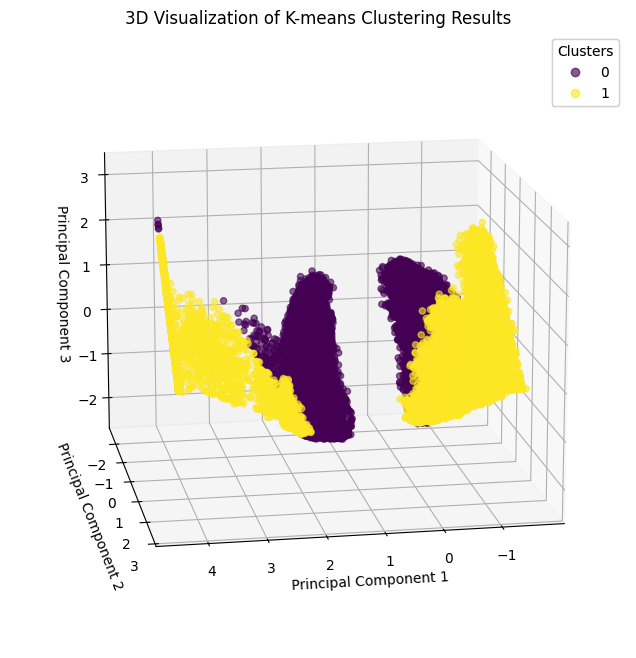

In [31]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Prepare data
pca_df = pd.DataFrame(
    pca_final_result[:, :3],
    columns=["PC1", "PC2", "PC3"]
)

# Extract values for x, y, and z
x = pca_df["PC1"]
y = pca_df["PC2"]
z = pca_df["PC3"]

# K-means clustering labels
clusters = kmeans.labels_

# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D, coloring according to clusters
scatter = ax.scatter(x, y, z, c=clusters, cmap='viridis', alpha=0.6)

# Add axis labels and title
ax.set_title("3D Visualization of K-means Clustering Results")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")

# Set view angle (camera view angles)
ax.view_init(elev=15, azim=80)

# Add legend (optional)
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend1)

# Show plot
plt.show()

In [32]:
# Alternatively, using Plotly for an interactive 3D scatter plot
fig = px.scatter_3d(
    pca_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color=clusters.astype(str),
    title="Wizualizacja 3D klasteryzacji K-means w Plotly"
)
fig.show()

(b) DBSCAN Clustering

In [26]:
# Sampling every 10th point
sampled_data = pca_final_result[::10, :]

2. Calculating distances to the nearest neighbor to determine the eps parameter

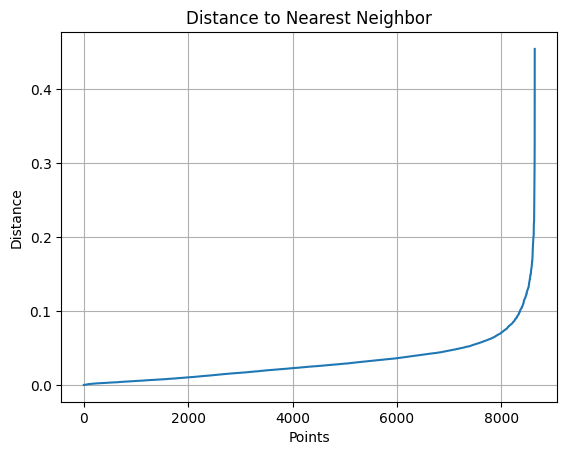

In [27]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Calculate distances to the nearest neighbor
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(sampled_data)
distances, indices = neighbors_fit.kneighbors(sampled_data)

# Plot distances to the second nearest neighbor
distances = np.sort(distances[:, 1], axis=0)
plt.plot(distances)
plt.title('Distance to Nearest Neighbor')
plt.xlabel('Points')
plt.ylabel('Distance')
plt.grid(True)
plt.show()


3. Applying DBSCAN

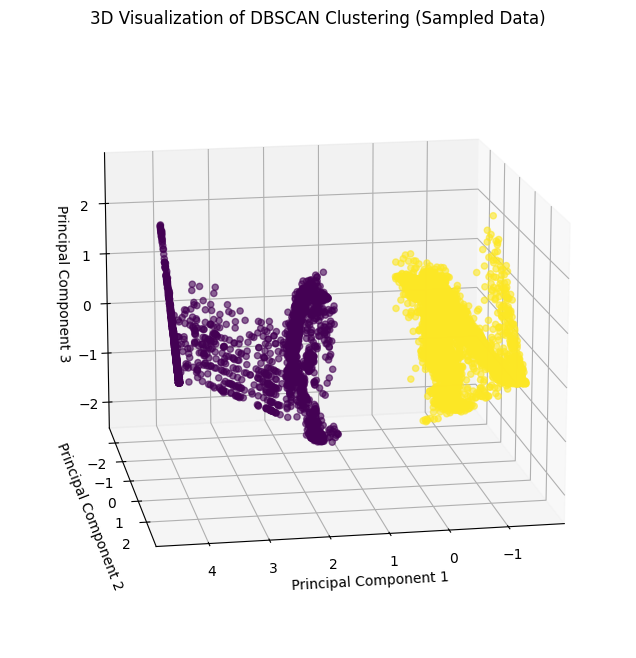

In [28]:
from sklearn.cluster import DBSCAN

# Try different values for eps (radius) and min_samples (minimum points in a cluster)
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(sampled_data)

# 3D Visualization of DBSCAN results (using sampled data)
x = sampled_data[:, 0]
y = sampled_data[:, 1]
z = sampled_data[:, 2]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=dbscan_labels, cmap='viridis', alpha=0.6)

# Add titles and labels
ax.set_title("3D Visualization of DBSCAN Clustering (Sampled Data)")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.view_init(elev=15, azim=80)

# Show plot
plt.show()


Association rules

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd

# Binarization or discretization of features
features['mean_bin'] = pd.cut(features['mean_power'], bins=3, labels=['low', 'medium', 'high'])
features['variance_bin'] = pd.cut(features['variance_power'], bins=3, labels=['low', 'medium', 'high'])

# One-hot encode the discretized features
encoded_features = pd.get_dummies(features[['mean_bin', 'variance_bin']])

# Apply Apriori algorithm
frequent_itemsets = apriori(encoded_features, min_support=0.1, use_colnames=True)
num_itemsets = len(frequent_itemsets)
rules = association_rules(frequent_itemsets, num_itemsets, metric="lift", min_threshold=1.0)

# Display rules
print(rules.head())


Sequence Patterns

In [ ]:
%pip install prefixspan

In [ ]:
from prefixspan import PrefixSpan


sequences = []
for i in range(len(features)):
    sequence = []
    if features['trend_strength_power'].iloc[i] > 0.5:
        sequence.append("high_trend")
    if features['variance_power'].iloc[i] > 100000:
        sequence.append("high_variance")
    if len(sequence) > 0:
        sequences.append(sequence)

ps = PrefixSpan(sequences)
patterns = ps.frequent(minsup=5)  # minimalne wsparcie
print(patterns)